In [1]:
# Function for generating histogram
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import datetime 
import import_ipynb
import histplot

importing Jupyter notebook from histplot.ipynb


In [2]:
ASC = '__ASC_ASCIIIn.mrk'
direct = 'C:/Users/tyron/Documents/Geoscience/weather/'

In [3]:
# Summer 2018 as an example
Summer18 = histplot.getData(18, direct, ASC, 152, 92, 6 , float)


In [4]:
def calc(precip_data, what_bin):
    hist, bin_edge = np.histogram(precip_data, bins = what_bin)
    log_y = np.log(hist)
    bin_val = np.zeros(len(what_bin)-1)
    for i in range(len(what_bin)-1):
        bin_val[i] = (what_bin[i] + what_bin[i+1])/2
    logx = np.log(bin_val)
    curve_fit = np.polyfit(logx, log_y,1)
    curve_fit[1] = np.exp(curve_fit[1])
    return curve_fit, bin_val

In [15]:
# Exponentials get from durations
def exponential(in_put, exclude, length):
    first_bin = np.zeros(length)
    for i in range(length):    
        first_bin[i] = np.percentile(in_put, i*(100/(length-1)))
    second_bin = np.unique(first_bin)
    stop1 = np.array([exclude])
    final_bin = np.setdiff1d(second_bin, stop1)
    curvefit, bin_vals = calc(in_put, final_bin)
    return curvefit, final_bin, bin_vals
    

In [6]:
# Exponentials get from intensity
def exponential_int(in_put, exclude):
    first_bin = np.zeros(51)
    for i in range(0, 51):    
        first_bin[i] = np.round(np.percentile(in_put, i*2),2)
    second_bin = np.unique(first_bin)
    stop1 = np.array([exclude])
    final_bin = np.setdiff1d(second_bin, stop1)
    curvefit, bin_vals = calc(in_put, final_bin)
    return curvefit, final_bin, bin_vals

In [7]:
def counting(data, want):
    counts = 0
    newdata = data[data < want]
    counts = len(newdata)
    return counts

In [16]:
def model_1(data, amount, howmuch):
    precip, nonprecip, preciptotal, totalprep = histplot.preciphist(data, len(data), amount, 1, 1)
    count = 0
    count1 = 0
    for i in range(0, len(precip)):
        hold = precip[i]
        hold1 = nonprecip[i]
        if hold > 0:
            count += 1
        if hold1 > 0:
            count1 += 1
    precip = precip[:count]
    nonprecip = nonprecip[:count1]
    preciptotal = preciptotal[:count]
    # Calculate intensities 
    inten = np.divide(preciptotal, precip)
    # Exponentials for precipitation duration 
    pre_exp,pre_f_bins, bin_vals = exponential(precip, 1, 21)
    # Exponentials for nonprecipitation duration 
    non_pre, nonpre_f_bins, nonp_b_vals = exponential(nonprecip, 1, 21)
    # Exponentials for Intensity of Precipitation duration
    intensity, inten_f_bins, inten_b_vals = exponential_int(inten, 0.01)
    # print(nonpre_f_bins)
    # Construct intervals and probabilities for precipitation durations
    Pre_prob = np.zeros(1)
    pre_bin_1 = counting(precip, pre_f_bins[0])
    Pre_prob[0] = pre_bin_1
    construct_1 = pre_exp[1]*np.exp(np.log(bin_vals)*pre_exp[0])
    Pre_prob = np.append(Pre_prob, construct_1)
    Pre_prob = Pre_prob/sum(Pre_prob)
    #print(Pre_prob)
    # Non_precipitation duration probs
    NonPre_prob = np.zeros(1)
    nonpre_bin_1 = counting(nonprecip, nonpre_f_bins[0])
    NonPre_prob[0] = nonpre_bin_1
    construct_2 = non_pre[1]*np.exp(np.log(nonp_b_vals)*non_pre[0])
    NonPre_prob = np.append(NonPre_prob, construct_2)
    NonPre_prob = NonPre_prob/sum(NonPre_prob)
    #print(NonPre_prob)
    # Intensity probs
    Intensity_prob = np.zeros(1)
    inten_bin_1 = counting(inten, inten_f_bins[0])
    Intensity_prob[0] = inten_bin_1
    construct_3 = intensity[1]*np.exp(np.log(inten_b_vals)*intensity[0])
    Intensity_prob = np.append(Intensity_prob, construct_3)
    Intensity_prob = Intensity_prob/sum(Intensity_prob)
    #print(Intensity_prob)
    # Precipitation intervals
    Pre_interval = [1]
    Pre_interval = np.append(Pre_interval, pre_f_bins)
    #print(Pre_interval)
    # NonPrecipitation intervals
    NonPre_interval = [1]
    NonPre_interval = np.append(NonPre_interval, nonpre_f_bins)
    #print(NonPre_interval)
    # Intensity intervals
    Intensity_interval = [0.01]
    Intensity_interval = np.append(Intensity_interval, inten_f_bins)
    #print(Intensity_interval)
    Model_outputs = 0;
    # Running the crude model
    for i in range(howmuch):
        minutes = 0;
        Model = np.zeros(len(data))
        start = np.random.randint(0, 1)
        while (len(data)-1 > minutes):
            # run probability of precipitation event duration      
            pre_index = np.random.choice(np.arange(len(Pre_prob)), p = Pre_prob)
            pre_duration = np.random.randint(Pre_interval[pre_index], Pre_interval[pre_index + 1]+1) #Histogram for these synthetic data, show that they are similar 
            # to what you put in. 
            # run probability of precipitation event intensity
            inten_index = np.random.choice(np.arange(len(Intensity_prob)), p = Intensity_prob)
            model_intensity = 0.01*np.random.randint(100*Intensity_interval[inten_index], 100*Intensity_interval[inten_index+1]+1)
            # run probability of non-precipitation event duration
            nonpre_index = np.random.choice(np.arange(len(NonPre_prob)), p = NonPre_prob) 
            nonpre_duration = np.random.randint(NonPre_interval[nonpre_index], NonPre_interval[nonpre_index + 1]+1)
            # For each of the synthetic data have a histogram and look at to see if it is similar to what we calcluated for observed data. 
            # Nonprecipitation starts first
            if start == 0: 
                if (len(data) > minutes + pre_duration + nonpre_duration):
                    for j in range(nonpre_duration):
                        Model[minutes] = 0
                        minutes += 1
                    for k in range(pre_duration):
                        Model[minutes] = model_intensity
                        minutes += 1
                else: 
                    if (len(data) < minutes + nonpre_duration):
                        for j in range(len(data) - minutes):
                            Model[minutes] = 0
                            minutes += 1
                    elif (len(data) < minutes + nonpre_duration + pre_duration):
                        for j in range(nonpre_duration):
                            Model[minutes] = 0
                            minutes += 1
                        for k in range(len(data) - minutes):
                            Model[minutes] = model_intensity
                            minutes +=1
            # Precipitation starts first
            if start == 1: 
                if (len(data) > minutes + pre_duration + nonpre_duration):
                    for k in range(pre_duration):
                        Model[minutes] = model_intensity
                        minutes += 1
                    for j in range(nonpre_duration):
                        Model[minutes] = 0
                        minutes += 1
                else: 
                    if (len(data) < minutes + pre_duration):
                        for k in range(len(data) - minutes):
                            Model[minutes] = model_intensity
                            minutes +=1
                    elif (len(data) < minutes + pre_duration + nonpre_duration):
                        for k in range(pre_duration):
                            Model[minutes] = model_intensity
                            minutes += 1
                        for j in range(len(data) - minutes):
                            Model[minutes] = 0
                            minutes += 1
        Model_outputs = Model
    return Model_outputs, data 

In [17]:
sample_output, compare_data = model_1(Summer18, 5000, 1)

C:\Users\tyron\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\tyron\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


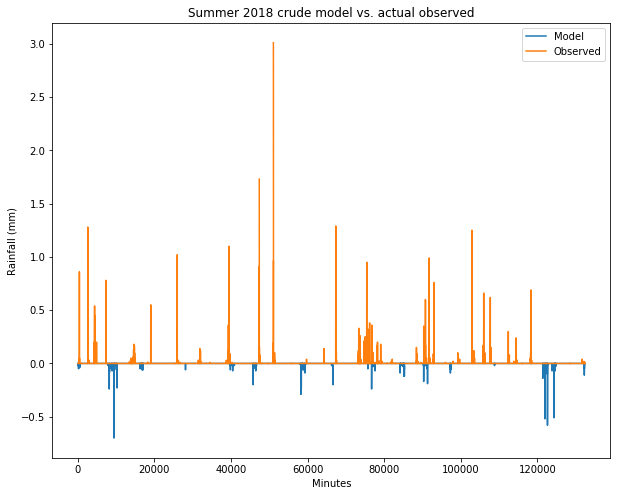

In [18]:
plt.figure(figsize = (10, 8))
plt.plot(-sample_output)
plt.plot(compare_data)
plt.title('Summer 2018 crude model vs. actual observed')
plt.xlabel('Minutes')
plt.ylabel('Rainfall (mm)')
plt.legend(['Model', 'Observed'])

In [19]:
Su_precip18, Su_nonprecip18, Su_preciptotal18, Su_totalprep18 = histplot.preciphist(Summer18, len(Summer18), 5000, 1, 1)

In [20]:
print(Su_precip18[:684])

[ 15.   6.  15.   1.  15.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   2.   3.  18.   4.   1.   1.   4.   7.  45.   2.   2.  26.  36.
   1.   1.  17.   2.   1.  18.   1.   1.   1.   1.   1.   1.   3.   2.
   1.   1.   2.   1.   1.   1.   1.   1.   1.   6.   1.   1.   1.   1.
  17.   3.   4.   2.   4.   1.   2.   1.   1.   1.   9.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   4.   2.   1.   1.   6.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   2.   1.   3.   9.  12.   2.  11.   1.
  15.   1.   1.   1.   1.   1.   1.  15.   3.   4.   2.   4.   8.   1.
   2.   2.   1.   1.  38.   1.   1.   5.   1.   1.   3.   5.   2.   1.
   1.   1.  16.   1.   1. 202.   1.   1.   1.   1. 116.   1.   3.   1.
   1.   1.   1.   2.  38.   3.   1.   2.   1.   1.   1.   1.   1.   5.
   1.   3.   1.  10.   1.  22.   1.   1.   1.   1.   1.  17.   2.   1.
   1.   1.   1.   1.   6.   2.   1.   2.   1.   1.   1.   4.   2.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   2.   6.   1.   1.   1.   1.
   1. 

In [21]:
print(compare_data)
print(len(Su_precip18))
print(len(Su_nonprecip18))
count_nonpre = 0
count_pre = 0
for i in range(0,5000):
    hold = Su_nonprecip18[i]
    hold1 = Su_precip18[i]
    if hold > 0:
        count_nonpre += 1
    if hold1 > 0:
        count_pre +=1
print(count_nonpre)
print(count_pre)

#print(Su_precip18)
#print(Su_nonprecip18)


[0. 0. 0. ... 0. 0. 0.]
5000
5000
684
684


In [22]:
Su_precip18 = Su_precip18[:count_pre]
Su_nonprecip18 = Su_nonprecip18[:count_nonpre]

In [23]:
print(Su_preciptotal18[:count_pre])
Su_preciptotal18 = Su_preciptotal18[:count_pre]


[6.400e+00 1.800e-01 4.200e-01 1.000e-02 8.380e+00 1.000e-02 1.000e-02
 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02
 1.000e-02 4.000e-02 6.000e-02 1.120e+00 1.200e-01 1.000e-02 1.000e-02
 8.000e-02 1.100e-01 4.420e+00 2.000e-02 2.000e-02 1.700e+00 6.330e+00
 1.000e-02 1.000e-02 9.400e-01 4.000e-02 1.000e-02 4.640e+00 3.000e-02
 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 4.000e-02 3.000e-02
 1.000e-02 1.000e-02 2.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02
 1.000e-02 1.000e-02 7.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02
 3.300e-01 3.000e-02 4.000e-02 2.000e-02 4.000e-02 1.000e-02 2.000e-02
 1.000e-02 1.000e-02 1.000e-02 1.700e-01 1.000e-02 1.000e-02 1.000e-02
 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 4.000e-02
 2.000e-02 1.000e-02 1.000e-02 6.000e-02 1.000e-02 1.000e-02 1.000e-02
 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 2.000e-02
 1.000e-02 3.000e-02 1.100e-01 1.200e-01 2.000e-02 1.300e-01 1.000e-02
 4.100

In [24]:
Su_inten18 = np.divide(Su_preciptotal18, Su_precip18)
print(Su_inten18)

[0.42666667 0.03       0.028      0.01       0.55866667 0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.02       0.02       0.06222222
 0.03       0.01       0.01       0.02       0.01571429 0.09822222
 0.01       0.01       0.06538462 0.17583333 0.01       0.01
 0.05529412 0.02       0.01       0.25777778 0.03       0.01
 0.01       0.01       0.01       0.01       0.01333333 0.015
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01166667 0.01       0.01
 0.01       0.01       0.01941176 0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01888889 0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01222222 0.01       0.01
 0.01181818

In [25]:
new_summer18 = np.zeros(len(compare_data))
minute = 0;
index = 0;
while(len(compare_data)-1 > minute):
    non = Su_nonprecip18[index]
    rain = Su_precip18[index]
    for i in range(int(non)):
        new_summer18[minute] = 0
        minute += 1
    for j in range(int(rain)):
        new_summer18[minute] = Su_inten18[index]
        minute += 1
    index += 1 


IndexError: index 684 is out of bounds for axis 0 with size 684

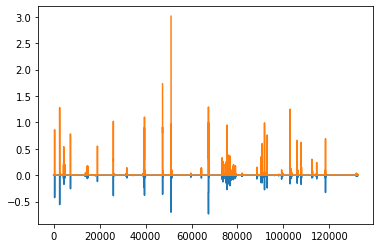

In [28]:
plt.plot(figsize = (10,8))
plt.plot(-new_summer18)
plt.plot(compare_data)

In [19]:
# Starts with a simple model accuracy, precip with precip. 
def mod_acc1(model, observed, pre_min):
    mod_accuracy = 0
    for i in range(len(observed)):
        mod = model[i]
        obs = observed[i]
        #if (mod == 0 and obs == 0):
            #mod_accuracy += 1
        if (mod > 0 and obs > 0):
            mod_accuracy += 1
        else: 
            mod_accuracy += 0
    mod_accuracy = 100*mod_accuracy/pre_min
    return mod_accuracy

In [20]:
# maintains exact match for precip
def mod_acc2(model, observed, pre_min):
    mod_accuracy = 0
    for i in range(len(observed)):
        mod = model[i]
        obs = observed[i]
        #if (mod == 0 and obs == 0):
           # mod_accuracy += 1
        if (mod > 0 and obs > 0 and mod == obs):
            mod_accuracy += 1
        else: 
            mod_accuracy += 0
    mod_accuracy = 100*mod_accuracy/pre_min
    return mod_accuracy

In [21]:
pre_min = sum(Su_precip18)
print(pre_min)

3427.0


In [22]:
model_accuracy = 0
for i in range(len(new_summer18)):
    mod = sample_output[i]
    obs = new_summer18[i]
    if (mod == 0 and obs == 0):
        model_accuracy += 1
    elif (mod > 0 and obs > 0):
        model_accuracy += 1
    else: 
        model_accuracy += 0
model_accuracy = model_accuracy/len(new_summer18)
print(mod_acc1(sample_output, new_summer18, pre_min))
print(mod_acc2(sample_output, new_summer18, pre_min))
pre_accuracy = mod_acc1(sample_output, new_summer18, pre_min)

2.0717829004960606
0.43770061278085787


In [23]:
print(model_accuracy)

0.9516066939921647


In [24]:
sample_output, compare_data = model_1(Summer18, 5000, 1)

Text(0.9, 0.7, 'Model percent without precipitation: 97.9 %')

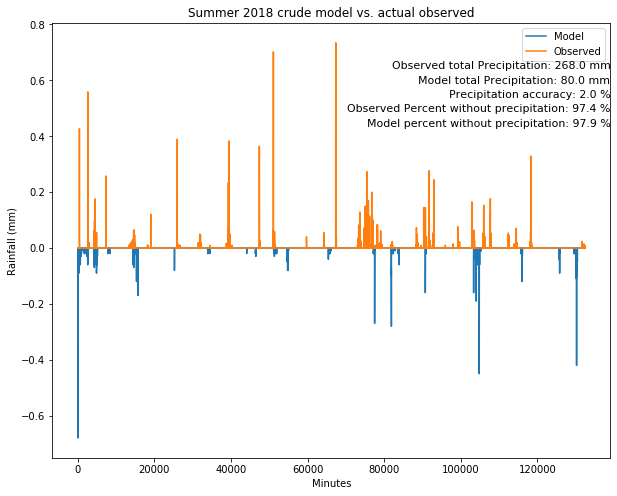

In [25]:
plt.figure(figsize = (10, 8))
plt.plot(-sample_output)
plt.plot(new_summer18)
plt.title('Summer 2018 crude model vs. actual observed')
plt.xlabel('Minutes')
plt.ylabel('Rainfall (mm)')
plt.legend(['Model', 'Observed'])
plt.figtext(0.9, 0.8, 'Observed total Precipitation: ' + str(round(Su_totalprep18)) + ' mm', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.775, 'Model total Precipitation: ' + str(round(sum(sample_output))) + ' mm', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.75, 'Precipitation accuracy: ' + str(round(pre_accuracy)) + ' %', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.725, 'Observed Percent without precipitation: ' + str(round(len(new_summer18[new_summer18 == 0])/len(new_summer18)*100,1)) + ' %', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.7, 'Model percent without precipitation: ' + str(round(len(sample_output[sample_output == 0])/len(sample_output)*100,1)) + ' %', fontsize = 11, ha = 'right')

In [26]:
average_precip = 0
avg_precip_accur = 0
for i in range(100):
    sample_output, compare_data = model_1(Summer18, 5000, 1)
    average_precip = average_precip + sum(sample_output)
    pre_accuracy = mod_acc1(sample_output, new_summer18, pre_min)
    avg_precip_accur = avg_precip_accur + pre_accuracy
average_precip = average_precip/100
avg_precip_accur = avg_precip_accur/100

print(average_precip)
print(avg_precip_accur)

109.73330000000118
2.825503355704697


In [27]:
# Key try to run the simulated data and spit out the coefficients. To make sure you know what is going on. 
# it looks like intensity and duration of non-precipitation events are off, perhaps not getting the upper ranges.
mod_precip18, mod_nonprecip18, mod_preciptotal18, mod_totalprep18 = histplot.preciphist(sample_output, len(sample_output), 5000, 1, 1)
print(len(mod_precip18))
print(len(mod_nonprecip18))
print(len(mod_preciptotal18))

5000
5000
5000


In [28]:
def count_zero(data, want):
    counts = 0
    newdata = data[data > want]
    counts = len(newdata)
    return newdata

In [29]:
mod_precip18 = count_zero(mod_precip18, 0)
print(len(mod_precip18))

290


In [30]:
print(mod_precip18)

[  6.   2.   2.   2.   1.  20.   6.   3.   1.  12.  13.   4.   9.   3.
   1.   4.   1.   5.   2.   2.   6.   2.   2.   1.   3.   1.   2.   2.
  61.   1.   1.   1.  19.   2.   2.   3.   4.   2.   1.   3.   4.   3.
   2.   2.   1.   2.   1.   2.   2.   1.   1.   1. 150.   6.   1.   3.
   2.   1.   2.   1.   2.   1.   2.   1.   6.   1.   3.   8.   1.   1.
   2. 151.   2.   1.   2.   3.   2.  13.   7.   1.   2.   1.   1.   2.
   1.   2.   1.   1.   5.   1.   8.   1.   2.   1.   3.  15.   1.   1.
   9.   5.   3. 121.  83.   2.   4.  12.   1.   1.   1.   1.   2.   4.
   1.   2.   2.   1.   1.   2.   3.   1.   1.   8.   2.   6.   3.   3.
   1.   2. 169.   1.   5.   3.   9.   9.   3.   1.  75.   4.   6.   2.
  19.   3. 156.  94.   1.   2.   2.   2.   2.   1.   6.   1.   1.   2.
   6.   1.   1.   4.   1.   1.   2.   6.   5.   5.   1.   1.   1.   3.
   9.   4.   2.   4.  17.   1.   2.   8.   1.   1.   3.   2.   3.   2.
   3.   3.   2.   2.   1.   2.   3.   7.   1.  11.   3.   2.   1.   2.
   1. 

In [31]:
mod_nonprecip18 = count_zero(mod_nonprecip18, 0)
print(len(mod_nonprecip18))
print(mod_nonprecip18)

290
[1.0000e+00 2.0000e+00 2.0000e+00 1.0000e+00 1.3000e+01 2.0000e+00
 3.0000e+00 1.0000e+00 2.0000e+00 7.8000e+01 1.0000e+00 1.0000e+00
 6.3900e+03 2.0000e+00 2.8000e+01 2.0000e+00 2.1200e+02 8.0000e+00
 2.0000e+00 1.0000e+00 1.0000e+00 2.0000e+00 5.1300e+02 2.0000e+00
 3.0000e+00 3.0000e+00 4.0000e+00 4.0000e+00 1.0000e+00 4.0000e+00
 3.0000e+00 4.0000e+00 3.0000e+00 5.1360e+03 7.0000e+00 2.0000e+00
 1.0000e+00 1.8460e+03 2.0000e+00 1.0000e+00 4.4600e+02 1.1000e+01
 1.6000e+01 1.4000e+01 1.8000e+01 6.0000e+00 6.2000e+01 2.0000e+00
 3.3000e+01 1.5000e+01 4.0000e+00 3.0000e+00 3.0000e+00 1.0000e+00
 9.0000e+00 3.0000e+00 3.0000e+00 2.0000e+00 3.0000e+00 1.0100e+02
 1.1899e+04 1.2000e+01 3.0000e+00 2.0000e+00 1.0000e+00 1.0000e+00
 7.6550e+03 1.4000e+01 2.0000e+00 1.0000e+00 5.0000e+01 2.3000e+01
 2.0000e+00 1.8000e+01 2.0000e+00 2.0000e+00 5.0000e+00 1.4200e+02
 2.0000e+01 1.0000e+00 8.0000e+00 2.0000e+00 6.0000e+00 2.0000e+00
 2.0000e+00 1.0000e+00 1.0000e+01 2.0000e+00 1.0000e+00 2.

In [32]:
print(mod_preciptotal18)

[0.06 0.04 0.02 ... 0.   0.   0.  ]


In [33]:
mod_preciptotal18 = count_zero(mod_preciptotal18, 0)


In [34]:
precip_coef, final_bins, bin_vals = exponential(mod_precip18, 1)
print(precip_coef)

[-0.33782808 47.87577593]


In [35]:
nonprecip_coef, np_final_bins, np_bin_vals = exponential(mod_nonprecip18, 1)
print(nonprecip_coef)

[-0.0812516  24.17398685]


In [36]:
mod_inten = np.divide(mod_preciptotal18, mod_precip18)
print(mod_inten)

[0.01 0.02 0.01 0.01 0.02 0.01 0.01 0.07 0.02 0.02 0.02 0.01 0.03 0.01
 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.08 0.01 0.02
 0.01 0.01 0.02 0.02 0.01 0.01 0.02 0.01 0.02 0.01 0.01 0.01 0.02 0.01
 0.02 0.02 0.07 0.03 0.01 0.02 0.02 0.02 0.01 0.01 0.02 0.01 0.02 0.01
 0.01 0.02 0.01 0.01 0.02 0.03 0.02 0.02 0.01 0.02 0.03 0.02 0.01 0.01
 0.01 0.07 0.02 0.02 0.01 0.01 0.55 0.02 0.02 0.02 0.01 0.02 0.02 0.01
 0.02 0.02 0.01 0.07 0.02 0.01 0.02 0.02 0.01 0.02 0.02 0.01 0.01 0.01
 0.02 0.02 0.01 0.01 0.01 0.01 0.02 0.01 0.01 0.01 0.06 0.01 0.01 0.01
 0.02 0.01 0.01 0.01 0.02 0.01 0.02 0.43 0.02 0.01 0.01 0.01 0.01 0.02
 0.02 0.02 0.09 0.01 0.02 0.01 0.02 0.01 0.02 0.01 0.02 0.01 0.02 0.01
 0.02 0.02 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.06 0.01 0.02 0.02
 0.02 0.01 0.69 0.02 0.15 0.01 0.02 0.06 0.02 0.01 0.02 0.02 0.04 0.01
 0.02 0.06 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.01 0.02 0.01 0.02 0.02
 0.02 0.01 0.01 0.02 0.01 0.02 0.01 0.03 0.02 0.04 0.05 0.01 0.02 0.02
 0.01 

In [45]:
inten_coef, inten_fb, inten_bv = exponential_int(mod_inten, 0.01)

In [46]:
print(inten_coef)

[-0.79131158  1.84005618]
